# Ultrasound Signal Imaging

## Introduction

Connor Mullen
10131211

The ultrasound signal that will form the image is obtained from an ultrasound transducer used as a sensor and converting mechanical energy (wave) into an electrical signal that will be processed. Ultrasound signals are also called ultrasound RF signals because of the frequencies that they carry. The main frequency is the one of the ultrasound transducer or resonator that is used to generate the acoustic wave and to receive the same wave that is reflected by tissues.

Producing an ultrasound image will require different steps:

* Generation and propagation of an ultrasound wave through the tissues
* Acquisition of the ultrasound signal reflected by the tissues
* Processing of the signal acquired
* Image Formation
* Image Processing

In this exercise we will focus on the signal processing, image formation and image processing based on data that is already in a binary file.

## Ultrasound Signal Processing

Ultrasound signals are usually acquired after some analog processing is performed:

1. Limitation is required to eliminate the large voltage pulse sent to the transducer for excitation, since in echographic ultrasound we use the same transducer for excitation and reception and the received signal is in the order of 2mVpp while the excitation pulse is between 400 and 900 Vpp.
   
2. Amplification is usually performed by a low noise amplifier (LNA) after limitation and before acquisition and it requires usually about 40dB in gain to boost the signal to values required by most acquisition cards. Some systems may acquire and then digitally amplify but it is not common.

3. Acquisition is then performed at a high enough sampling frequency to avoid aliasing (Nyquist theorem), we should consider that the frequency of the signal is broad band but centered around the transducer's resonance (typically 2-15MHz).

4. Some systems may perform some processing using DSPm and this typically consists on filtering but can also include image formation.

In this example the signal from a transducer was acquired after limitation and amplification and it was digitized by a 12-bit acquisition card sampling at $125 MHz$ with a $2 Vpp$ maximum voltage. A total of $26$ lines were acquired separated by $1 mm$ and the file provided includes all these lines $MultipleUSSignalsI.dat$. The data in this file was stored as unsigned integers of 16 bits.

We will first plot the signal from the first line with the time scale:

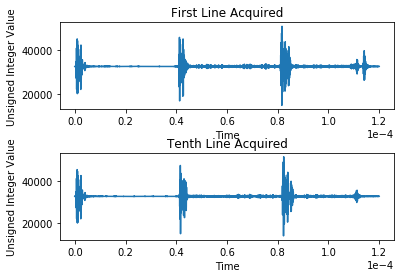

In [1]:
# The magic command to have graphs inline in the notebook
%matplotlib inline

# Packages that will allow to do math, numerical operations, array operations and plotting
import scipy as Sci
import numpy as np
import matplotlib.pyplot as plt

# Known parameters
TotLines = 26  #total lines
fs = 125e6   #sampling frequency
LineSeparation = 1  #separation between lines 1mm
c = 1500  #speed of sound

# we use a simple open command for the file (basic Python)
# REMEMBER to keep capitals if the OS is Linux !
f = open('../library/MultipleUSSignalsI.dat','rb')   
# we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
Lines = np.fromfile(f,count=-1,dtype=np.uint16)
f.close() #close the file
# we will now populate a 2D matrix for the lines
SamplesPerLine=int(len(Lines)/TotLines)  # the size of the array divided by the 26 lines should give the samples per line

# we arrange the data now in a 2D array since there are multiple lines
LinesRF=Lines.reshape(TotLines,SamplesPerLine,order='F').copy()  #columns,rows

# in order to plot we need a time axis that we can obtain from the sampling frequency
time=np.arange(0,SamplesPerLine/fs,1/fs)

#now we plot two lines acquired to double check (15000 samples)
plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(time,LinesRF[0]) #first line
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(212)
plt.plot(time,LinesRF[10]) #10th line
plt.title('Tenth Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

The first thing we notice here is that the data is not centered at zero since this are unsigned integers. It would be required for the calculations to eliminate this dc component and we can use what we know from the Fourier Notebook to do this.

Next, we will analyze this signal visually (zoom) to estimate the frequency of the transducer used.

We will then perform a Fourier transform to obtain the central frequency of the transducer.

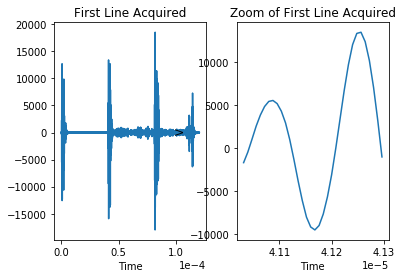

In [2]:
LinesRF=LinesRF-np.mean(LinesRF)

plt.subplots_adjust( hspace = .5 )
plt.subplot(121)
plt.plot(time,LinesRF[0]) #first line
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

inx1=np.where(time>0.4103e-4)
inx1=inx1[0]
inx2=np.where(time>0.413e-4)
inx2=inx2[0]

plt.subplot(122)
plt.plot(time[inx1[0]:inx2[0]],LinesRF[0][inx1[0]:inx2[0]])
plt.title('Zoom of First Line Acquired')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Since 1.5 cycles of the signal are in this zoom between $0.4103\times 10^{-4}$ and $0.413\times ^{-4}$ we then have a frequency of $\frac{1}{(0.413\times 10^{-4}-0.4103\times 10^{-4})/1.5}=5.5MHz$

### Activity 1 - Add a code cell and plot again the first line but using depth of tissues instead of time as the x axis and estimate at which distance within the tissues you expect to find the first large interface.
<font color="red"> Observing the depth plot created below, the first large interface appears to be around the 31mm mark. </font>

We will now obtain the frequency of the signal using DFT. 

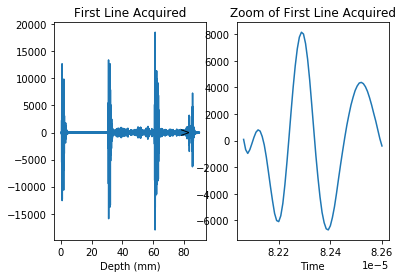

In [3]:
#added code, depth = 1e3*time*c/2 in mm
plt.subplots_adjust( hspace = .5 )
plt.subplot(121)
plt.plot(1e3*time*c/2,LinesRF[0]) #first line
plt.title('First Line Acquired')
plt.xlabel('Depth (mm)')
#c = d/t, d = c*t 
inx1=np.where((1e3*time*c/2)>((1e3)*(0.4103e-4)*c))
inx1=inx1[0]
inx2=np.where((1e3*time*c/2)>((1e3)*(0.413e-4)*c))
inx2=inx2[0]

plt.subplot(122)
plt.plot(time[inx1[0]:inx2[0]],LinesRF[0][inx1[0]:inx2[0]])
plt.title('Zoom of First Line Acquired')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

The maximum is 131.276098 and it is found at 4.966667 MHz


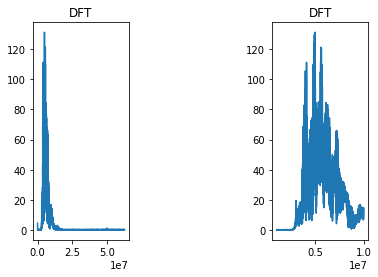

In [4]:
#let's obtain the spectrum
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,125e6/2,125e6/SamplesPerLine)
Y=np.fft.fft(LinesRF[0])
Pyy=abs(Y)/SamplesPerLine
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing

#preparing the plotting
plt.subplots_adjust( wspace = 1.5 )
plt.subplot(121)

plt.plot(f[:int(SamplesPerLine/2)], Pyy[:int(SamplesPerLine/2)])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Zooming between 1 and 10 MHz
inx1=np.where(f>1e6)
inx1=inx1[0]
inx2=np.where(f<10e6)
inx2=inx2[0]   #Note: when using where the indexes will be ordered from the first that fulfills condition to the last
plt.subplot(122)
plt.plot(f[inx1[0]:inx2[-1]], Pyy[inx1[0]:inx2[-1]])   #Note: in an array, element -1 is the last element
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#The frequency at which the maximum is observed
mm=np.argmax(Pyy[:int(SamplesPerLine/2)]) #this gives the index where the max is found
print("The maximum is %f and it is found at %f MHz" % (max(Pyy[:int(SamplesPerLine/2)]),f[mm]/1e6))

ftx=f[mm]/1e6   #frequency of the transducer in MHz

We can see that the frequency of that transducer is $4.97MHz$ and as you can see, using the DFT gave us more precision than estimation.

### Activity 2 - What is the frequency of this transducer with uncertainty considering the sampling frequency?

<font color="red"> Sampling is done at 125 MHz while (from above) the transducer frequency is done at 4.97MHz. Because we are sampling at such a high rate (>>2*Tranducer frequency) we are following the nyquist theorem, so we should recieve a clear signal. Since the actual transucer signal is a broad band signal that centers itself around the resonance frequency, we may not get the exact transducer frequency, however we should fall within its bandwidth so in terms of getting the correct signal back we should be okay despite uncertainty. </font>

## Attenuation Compensation

Tissues will attenuate the wave exponentially as a function of depth and frequency. This attenuation is usually expressed in $Np/m/MHz$. Compensating for this attenuation is called **Time-Gain-Compensation** or **TGC**. Assuming that the tissues have attenuated this signal $\alpha=4Np/m/MHz$ we will compensate for this attenuation and plot the real TGC compensated signal. Since the attenuation is exponential so we can compensate using:

$$ RF_{com}=RF e^{\mu d}\;\;\mu=\alpha f\;\;\;\;c\approx 1500m/s$$

### Activity 3 - In the following code: 1) comment all lines with #? explaining the purpose of the line; 2) add an appropriate and descriptive title to all plots; 3) add an appropriate and descriptive label to the x axis with units; 4) what is the purpose of the $/2$ in the first line?
<font color="purple"> 4) The '/2' in the first line is used because the signal is actually an echo, therefore we have to wait for the signal to reach the target, and return back to the sender. Thus the return signal has travelled twice the distance and in order to find actual depth we divide by 2. </font>

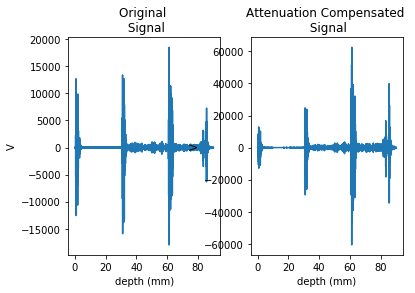

In [5]:
att=4   #alpha (attenuation) in Np/m/MHz
d=time*c/2                      #does the formula for finding depth (distance). Needs to travel to target and back so divide by 2
ffatt=np.exp(att*ftx*d)         #considers the attenuation of the signal using equation e^attenuation*depth*freq of transducer(Mhz)
LinesRFC=LinesRF*ffatt          #the amplitude of the signal (LinesRFC) will now compensate for the attenuation.

#Plotting
plt.subplot(121)
plt.xlabel('depth (mm)')
plt.ylabel('V')
plt.title('Original \n Signal')
plt.plot(d*1e3,LinesRF[0])

plt.subplot(122)
plt.xlabel('depth (mm)')
plt.ylabel('V')
plt.title('Attenuation Compensated \n Signal')
plt.plot(d*1e3,LinesRFC[0])


## Image Formation

The first step to forming any image is determine what gives the contrast of this image. In ultrasound, the contrast is defined as the intensity of the reflexion. We then need to determine this intensity and the standard way to do this is to obtain the envelope of the signal and assign an intensity value (grayscale) to this intensity, with the brightest pixels having the highest amplitude. This is done using the magnitude of the signal after a **Hilbert transform**.

Text(0.5, 0, 'Depth (mm)')

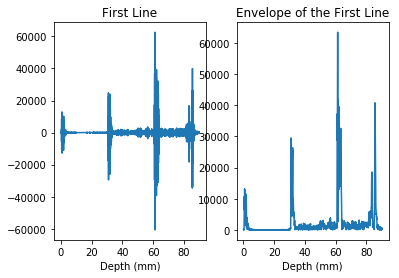

In [6]:
#importing the module for Hilbert transform
from scipy.signal import hilbert

#Performing the Hilbert Transform
LinesRFC_E=hilbert(LinesRFC)
LinesRFC_E=abs(LinesRFC_E)
#Plotting
plt.subplot(121)
plt.plot(d*1e3,LinesRFC[0,:])
plt.title('First Line')
plt.xlabel('Depth (mm)')
plt.subplot(122)
plt.plot(d*1e3,LinesRFC_E[0,:])
plt.title('Envelope of the First Line')
plt.xlabel('Depth (mm)')

## Image Rendering

We can now render the image by doing a 2D representation. We need to determine the second axis defined by the distance between the lines (known to be $1mm$) and then plotting in 2D. In addition, we need to render the pixels in a logarithmic scale for intensity (in decibels).

Text(0, 0.5, 'Length (mm)')

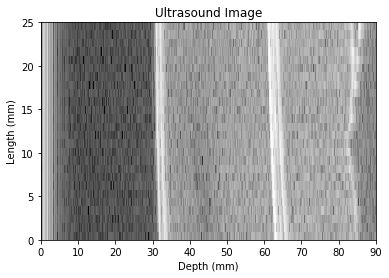

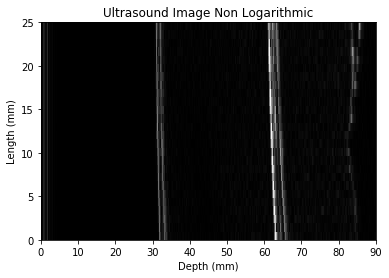

In [7]:
#the line axis
LineAxis=np.arange(0,26,1)  #defined in mm from 0 to 25 mm separated by 1 mm

#images need to be in decibels so we can see all the contrast
Image=20*np.log10(LinesRFC_E/LinesRFC_E.max())   #Image in decibels
ImageBW=LinesRFC_E                                 #Image in amplitude

#Plotting
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(Image, aspect='auto', extent=[d.min()*1e3,d.max()*1e3,LineAxis.min(),LineAxis.max()])
plt.title('Ultrasound Image')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ImageBW, aspect='auto', extent=[d.min()*1e3,d.max()*1e3,LineAxis.min(),LineAxis.max()])
plt.title('Ultrasound Image Non Logarithmic')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

### Activity 4 - Investigate the use of imshow and how were the axes defined
<font color="red"> The function imshow() basically displays an image on the axes. The parameter 'extent' provides the bounds of the image that will be used. it works like this: extent(left,right,bottom,top). So for the left parameter we use the minimum depth calculated and multply by 1000 (in order to get into mm) which according to the image is 0mm, the right parametre we use the maximum depth calculated and multiply by 1000 to get into mm, which according to the iamge is 90mm. The left and right parameters can then be seen in the images as the x axis. Then for the top and bottom parameters we use the LineAxis variable defined above which is measured in mm as well and stretches from 0mm (bottom) to 25mm (top) as can be seen from the images y axis. </font>

## Image Processing

We will finally apply one of the most common filters that are used in ultrasound imaging: the median filter. This will make the image less "grainy" to the user.

We will also implement a typical "cutoff" in the displayed image, which allow the user to make black anything below a specific threshold defined in decibels.

### Activity 5 - The processing is coded below, add the code required to obtain your final image.

Text(0, 0.5, 'Length (mm)')

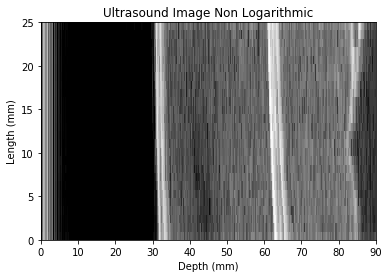

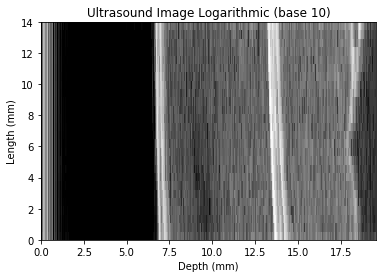

In [8]:
from scipy.signal import medfilt

#we cut anything below -60dB
cutdb=-60
inx=np.where(Image<cutdb)
ImageC=np.copy(Image)
ImageC[inx]=cutdb

#and we filter using a 3x3 median filter
ImageF=medfilt(ImageC,3)

plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.imshow(ImageF, aspect='auto', extent=[d.min()*1e3,d.max()*1e3,LineAxis.min(),LineAxis.max()])
plt.title('Ultrasound Image Non Logarithmic')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

#added code - logarithmic scale
plt.figure()
plt.set_cmap(plt.gray())
plt.imshow(ImageF, aspect='auto', extent=[d.min()*1e3,10*np.log10(d.max()*1e3),LineAxis.min(),10*np.log10(LineAxis.max())])
plt.title('Ultrasound Image Logarithmic (base 10)')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

## Challenge \# 10 - Hilbert Transform

Create a markdown explaining the use of the Hilbert transform to obtain the envelope of a signal including the mathematical equations.

## Challenge \# 11 - Sampling Frequency

The signal used in this exercise is obtained with a very high sampling frequency compared to many ultrasound systems. It is typical that we would have 4 samples per wavelength in any system. Sub-sample the signal in this example to this new sampling frequency and obtain the image again. Discuss what you observe.

## Summary

In this example, we rendered an ultrasound image from RF signals.

* Signal Processing
* Image Formation
* Image Rendering
* Image Processing (median filter)

Comments and corrections welcome!

References
---------------

* Oppenheim, A. V., and A. S. Willsky. "Signals and Systems." Prentice-Hall, (1997).